In [139]:
import numpy as np
import pandas as pd
from src.data_loader import *
# from src.strategy import *
from src.index import *
from src.strategy2 import *
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score,  classification_report, mean_squared_error
from sklearn import linear_model

from keras.models import Sequential # deep learning model
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import optimizers # 옵티마이저 
import seaborn as sns

import datetime
import tensorflow as tf
import pandas_datareader as pdr
import FinanceDataReader as fdr
from fredapi import Fred
fred = Fred(api_key='d929757b1ad9cd1d5115620a50badb0a')
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')
# ! pip install fredapi

In [115]:
data = DataGenerator(data_type='db').data_search(ticker='AAPL')

기존 데이터 불러오기 성공


In [116]:
data

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
1992-12-16,0.502232,0.508929,0.486607,0.491071,0.403157,225926400.0
1992-12-17,0.493304,0.513393,0.493304,0.507813,0.416901,233867200.0
1992-12-18,0.513393,0.529018,0.511161,0.520089,0.426980,235457600.0
1992-12-21,0.520089,0.535714,0.517857,0.532366,0.437059,256065600.0
1992-12-22,0.533482,0.546875,0.533482,0.541295,0.444389,280168000.0
...,...,...,...,...,...,...
2022-11-02,148.949997,152.169998,145.000000,145.029999,144.789810,93604600.0
2022-11-03,142.059998,142.800003,138.750000,138.880005,138.650009,97918500.0
2022-11-04,142.089996,142.669998,134.380005,138.380005,138.380005,140716700.0


In [117]:
def add_feature(df, **kwargs):
    
    fred = Fred(api_key='d929757b1ad9cd1d5115620a50badb0a')
    
    data = df.copy()

    data["AC_pct"]                                 = data['Adj Close'].pct_change()                                         # 수정 종가 변동률 
    data["sma(5)"]                                 = sma(data, 5)
    data["sma(20)"]                                = sma(data, 20)
    data["volume_sma5"]                            = data["Volume"].rolling(5).mean()
    data["volume_sma20"]                           = data["Volume"].rolling(20).mean()
    data["normalized_value"]                       = (data["Adj Close"] - data["Low"]) / (data["High"] - data["Low"])       # 정규화 주가
    data["T10Y2Y"]                                 = fred.get_series('T10Y2Y', data.index[0])
    data["T10Y3M"]                                 = fred.get_series('T10Y3M', data.index[0])
    # data["High_Yield"]                             = fred.get_series('BAMLH0A0HYM2', data.index[0])        
    # data["TED"]                                    = fred.get_series('TEDRATE', data.index[0])
    # data["inflation"]                              = fred.get_series('T10YIE', data.index[0])
    data["WTI"]                                    = fred.get_series('DCOILWTICO', data.index[0])
    data["VIX"]                                    = fred.get_series('VIXCLS', data.index[0])
    data["NASDAQ"]                                 = fred.get_series('NASDAQCOM', data.index[0])
    data["Log_Close"]                              = np.log(data["Adj Close"])
    data["RSI"]                                    = rsi(data, **kwargs)
    data[["macd","macd_signal","macd_oscillator"]] = macd(data, **kwargs)
#-------------------------------------------------------------------------------------------------------------------------------------------

    typical_price                                  = (data["High"] + data["Low"] + data["Adj Close"]) / 3
    money_flow                                     = typical_price * data["Volume"]

    positive_flow =[] 
    negative_flow = [] 
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]: 
            positive_flow.append(money_flow[i-1]) 
            negative_flow.append(0)  
        
        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(money_flow[i-1]) 
            positive_flow.append(0)  
        
        else: 
            positive_flow.append(0)
            negative_flow.append(0)

    period = 14
    positive_mf =[]
    negative_mf = [] 
    for i in range(period-1, len(positive_flow)):
        positive_mf.append(sum(positive_flow[i+1-period : i+1]))
    for i in range(period-1, len(negative_flow)):
        negative_mf.append(sum(negative_flow[i+1-period : i+1]))

    mfi = 100 * (np.array(positive_mf) / (np.array(positive_mf)  + np.array(negative_mf) ))
    data = data[14:]
    data["MFI"] = mfi

    #-------------------------------------------------------------------------------------------------------------------------------------------
    
    dollar = pdr.get_data_yahoo('DX-Y.NYB', start=data.index[0], end=data.index[-1]) #----- 달러지수
    data["dollar_index"] = dollar["Adj Close"]
        
    #-------------------------------------------------------------------------------------------------------------------------------------------

    
    OBV = []
    OBV.append(0)
    for i in range(1, len(data['Adj Close'])):
        if data['Adj Close'][i] > data['Adj Close'][i-1]: 
            OBV.append(OBV[-1] + data['Volume'][i]) 
        elif data['Adj Close'][i] < data['Adj Close'][i-1]:
            OBV.append( OBV[-1] - data['Volume'][i])
        else:
         OBV.append(OBV[-1])
    data['OBV'] = OBV
    data["OBV_mv20"] = data["OBV"].rolling(20).mean()
    
    #-------------------------------------------------------------------------------------------------------------------------------------------
    
    signal = []
    for idx in range(len(data['Adj Close'])):
        if idx == 0 or idx+1 == len(data['Adj Close']):
            signal.append(0)   
        else:
            if data['Adj Close'].iloc[idx-1]> data['Adj Close'].iloc[idx] and data['Adj Close'].iloc[idx+1]> data['Adj Close'].iloc[idx]:
                signal.append(1) #----- 상승
            elif data['Adj Close'].iloc[idx-1]< data['Adj Close'].iloc[idx] and data['Adj Close'].iloc[idx+1]< data['Adj Close'].iloc[idx]:
                signal.append(-1) #----- 하락
            else:
                signal.append(0) #----- 횡보추세
    data['trend'] = signal
        
    #-------------------------------------------------------------------------------------------------------------------------------------------
    
    data['r_signal']    = [-1 if data.iloc[i]['RSI']>70 else 1 if data.iloc[i]['RSI']<30 else 0 for i in range(len(data))] 
    data['m_signal']    = [-1 if data.iloc[i]['macd']<data.iloc[i]['macd_signal'] else 1 if data.iloc[i]['macd']>data.iloc[i]['macd_signal'] else 0 for i in range(len(data))] 
    # data["Target"] = [2 if data.iloc[i]["AC_pct"] > 0  else 1 if data.iloc[i]["AC_pct"] < 0  else 0 for i in range(len(data))]

    #-------------------------------------------------------------------------------------------------------------------------------------------
    
    
    
    #-------------------------------------------------------------------------------------------------------------------------------------------
    
    target = []
    for i in range(1, len(data)+1):
        target.append(data.iloc[i-1:i, -3:].values.sum())
    data['tt'] = target

    data['position'] = 0
    data['position'].mask(data['tt'] >= 1, 'buy', inplace=True)
    data['position'].mask(data['tt'] == 0, 'hold', inplace=True)
    data['position'].mask(data['tt'] <= -1, 'sell', inplace=True)

    data['position'].mask(data['position'] == 'hold', 0, inplace=True)  # 0은 hold
    data['position'].mask(data['position'] == 'buy', 1, inplace=True)   # 1은 매수 
    data['position'].mask(data['position'] == 'sell', 2, inplace=True)  # 2는 매도
    data['position'] = data['position'].astype('int')
    
    #-------------------------------------------------------------------------------------------------------------------------------------------
    
    data.dropna(axis=0, inplace=True)
    data.drop(["Open","High","Low","Close"], axis=1, inplace=True)
    
    return data

In [118]:
data = add_feature(data)

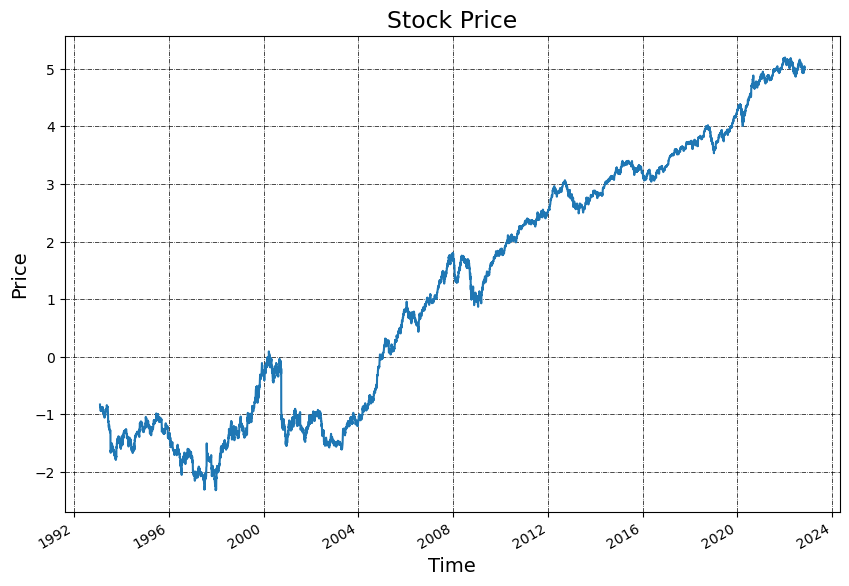

In [104]:
data['Log_Close'].plot(figsize=(10, 7))
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

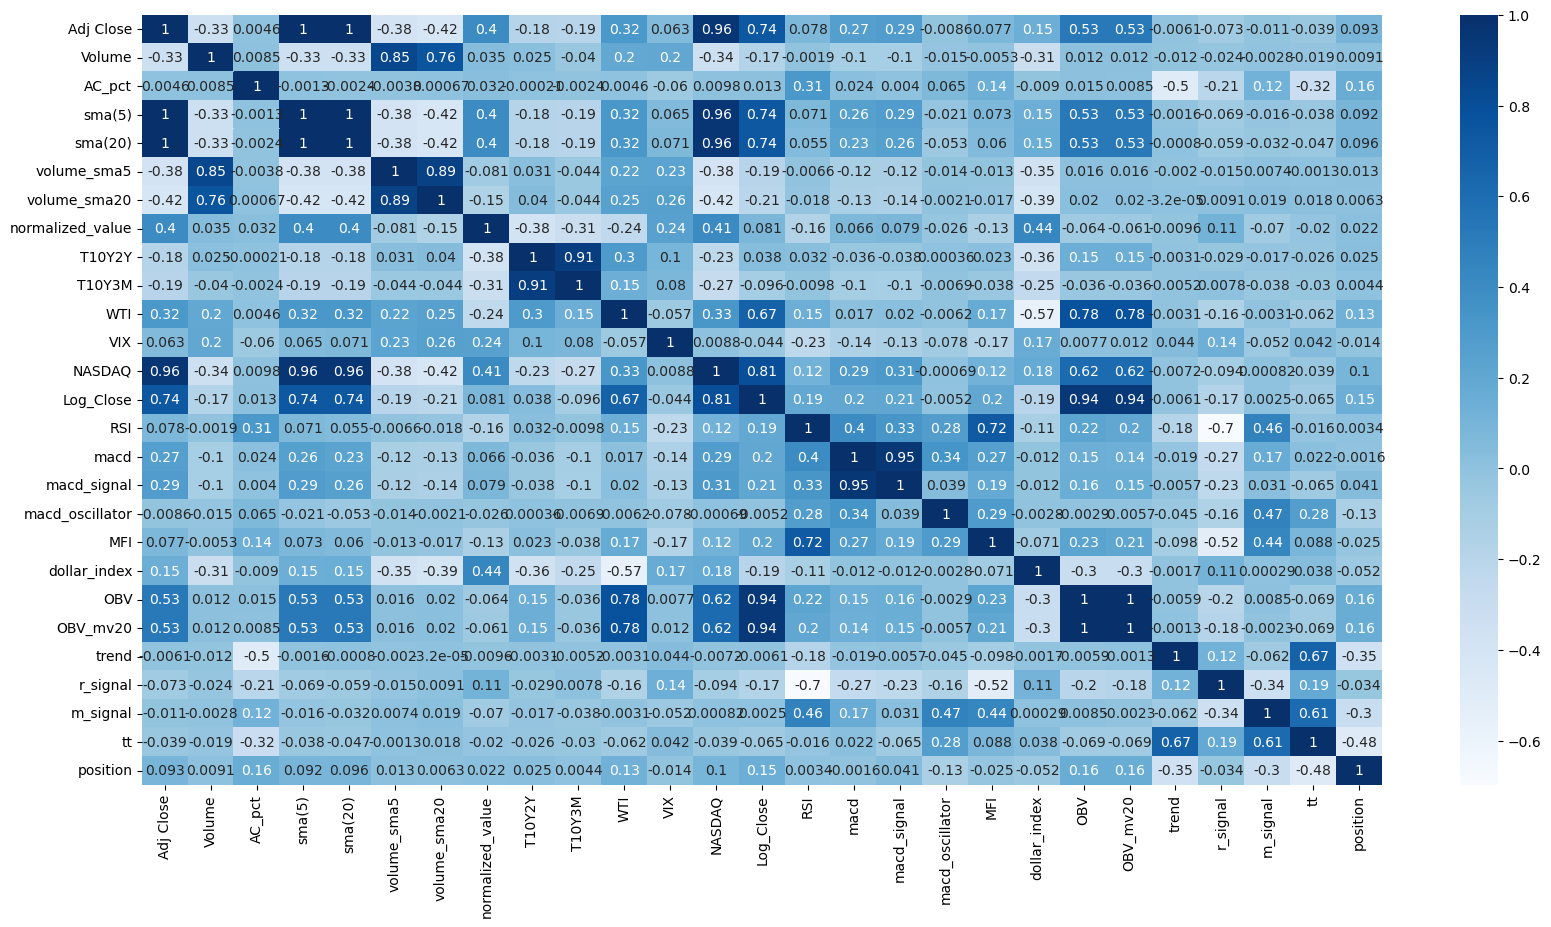

In [119]:
plt.figure(figsize = (20,10))
sns.heatmap(data.corr() , annot=True, cmap='Blues')
plt.show()

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [159]:
X1 = data.drop('position', axis=1)
y1 = data[['position']]

In [160]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 0)
X_train1.shape, X_test1.shape

((5920, 26), (1481, 26))

In [161]:
sfs = SFS(RandomForestClassifier(n_estimators=10, random_state=0, n_jobs = -1),
         k_features = 10,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 4,
          n_jobs= -1
         ).fit(X_train1, y_train1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    8.3s finished

[2022-11-09 18:26:20] Features: 1/10 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished

[2022-11-09 18:26:21] Features: 2/10 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s finished

[2022-11-09 18:26:23] Features: 3/10 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.2s finished

[2022-11-09 18:

In [162]:
sfs.k_feature_names_

('Adj Close',
 'Volume',
 'AC_pct',
 'sma(5)',
 'sma(20)',
 'volume_sma5',
 'volume_sma20',
 'normalized_value',
 'MFI',
 'tt')

In [164]:
sfs2 = SFS(RandomForestClassifier(n_estimators=10, random_state=0, n_jobs = -1),
         k_features = (1, 10),
          forward= False,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 4,
          n_jobs= -1
         ).fit(X_train1, y_train1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    3.6s finished

[2022-11-09 18:29:07] Features: 25/2 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.7s finished

[2022-11-09 18:29:10] Features: 24/2 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.3s finished

[2022-11-09 18:29:12] Features: 23/2 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    2.4s finished

[2022-11-09 18:

In [165]:
sfs2.k_feature_names_

('Volume',
 'AC_pct',
 'sma(5)',
 'sma(20)',
 'volume_sma5',
 'normalized_value',
 'T10Y2Y',
 'VIX',
 'RSI',
 'tt')

In [68]:
import statsmodels.api as sm

## Model

In [127]:
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

In [145]:
# 타겟값 분리
X = data.drop('AC_pct', axis=1)
y = data[['AC_pct']]

In [146]:
# 스탠다드 스케일러 사용 단, 타겟값은 적용하지 않음
ms = StandardScaler()
X  = ms.fit_transform(X)

In [147]:
X = pd.DataFrame(X, columns=data.columns[:-1], index=data.index)

In [148]:
# 학습비율
train_size = int(len(X) * 0.85)
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_test = y.iloc[:train_size, :], y.iloc[train_size:, :]

In [149]:
X_train

,Adj Close,Volume,AC_pct,sma(5),sma(20),volume_sma5,volume_sma20,normalized_value,T10Y2Y,T10Y3M,...,macd_signal,macd_oscillator,MFI,dollar_index,OBV,OBV_mv20,trend,r_signal,m_signal,tt
Datetime,,,,,,,,,,,,,,,,,,,,,
1993-02-04,-0.545086,-0.502952,-0.544833,-0.543937,-0.499254,-0.393816,-1.032311,1.268123,1.658159,-1.083364,...,0.002238,-0.616211,0.266500,-1.583298,-1.565064,-0.000577,0.223060,-0.033204,0.055164,-1.146354
1993-02-05,-0.545512,-0.075040,-0.544918,-0.543985,-0.436847,-0.385903,0.462145,1.325424,1.594338,-1.084040,...,0.002238,-0.022406,0.253897,-1.590057,-1.566374,-0.000577,0.223060,-0.033204,0.055164,-1.146354
1993-02-08,-0.545655,-0.307269,-0.545099,-0.544058,-0.411936,-0.384657,-0.022664,1.279583,1.603455,-1.090808,...,0.002238,-0.690920,0.249050,-1.595225,-1.568193,1.423972,0.223060,-0.033204,1.020332,0.045242
1993-02-09,-0.545583,-0.421084,-0.545227,-0.544102,-0.377310,-0.402880,-1.906114,1.279583,1.649042,-1.089116,...,0.002238,-0.700857,0.218027,-1.590837,-1.569475,-1.425126,0.223060,-0.033204,-0.910005,1.236839
1993-02-10,-0.545797,-0.341591,-0.545388,-0.544176,-0.374790,-0.391243,0.106269,1.187901,1.630807,-1.086409,...,-0.033079,-0.754483,0.261653,-1.595769,-1.571188,-0.000577,0.223060,-1.274318,-0.910005,1.236839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-07,0.586175,-0.605851,0.545904,0.513646,-0.591473,-0.845813,0.495747,-0.725955,-0.475285,0.623846,...,1.697477,0.624403,0.093937,0.950553,0.939175,-0.000577,0.223060,1.207911,1.020332,0.045242
2018-05-08,0.591667,-0.756643,0.566858,0.517624,-0.653358,-0.845817,0.598011,-0.725955,-0.466168,0.559212,...,1.909382,0.500612,0.129807,0.952642,0.940008,-0.000577,0.223060,1.207911,1.020332,0.045242
2018-05-09,0.599751,-0.812368,0.580197,0.522262,-0.759902,-0.845288,0.445377,-0.725955,-0.447933,0.638058,...,2.015335,0.767277,0.122051,0.954349,0.941010,-0.000577,-2.422562,1.207911,0.055164,-1.146354


In [150]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [151]:
y_pred = lm.predict(X_test)

In [152]:
print(mean_squared_error(y_test, y_pred))

0.0031520598019030214


In [153]:
print(y_pred)

[[-0.02730738]
 [-0.04272191]
 [ 0.01343082]
 ...
 [-0.11319319]
 [ 0.14262912]
 [-0.02493426]]


Text(0.5, 1.0, 'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

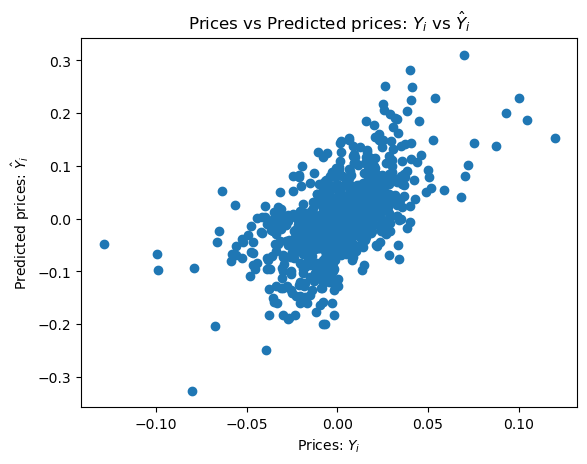

In [154]:
plt.scatter(y_test, y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

In [155]:
lm.coef_

array([[ 1.44229471e+00, -2.13338116e-04,  8.34357403e-01,
        -2.25954431e+00, -2.06188256e-03,  7.80691045e-04,
         2.96233370e-03,  1.76270308e-03, -2.26137809e-03,
         1.53758500e-03,  1.60559325e-04, -4.43967413e-03,
         3.19426999e-03,  1.14148539e-02, -4.99508822e-02,
        -2.72297847e-02, -8.05373962e-02, -3.81899210e-03,
         5.17978702e-04,  2.70568345e-02, -2.96737987e-02,
        -8.91143449e-03,  1.20256240e-03,  3.01992110e-03,
        -3.25052993e-03,  7.67937995e-05]])

In [156]:
lm.intercept_

array([0.00090631])

In [157]:
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(y, X).fit() # yeah, sm.OLS take paramteres in inverted order :)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 AC_pct   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     162.8
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        18:22:12   Log-Likelihood:                 17685.
No. Observations:                7401   AIC:                        -3.532e+04
Df Residuals:                    7376   BIC:                        -3.515e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0011      0.000      4.257      0.000       0.001       0.002
Adj Close            0.3439      0.023     15.067      0.000       0.299       0.389
Volume              -0.0004      0.001     -0.827      0.408      -0.001       0.001
AC_pct               0.1997      0.041      4.823      0.000       0.119       0.281
sma(5)              -0.5391      0.057     -9.413      0.000      -0.651      -0.427
sma(20)             -0.0016      0.001     -2.237      0.025      -0.003      -0.000
volume_sma5          0.0013      0.001      1.939      0.052   -1.39e-05       0.003
volume_sma20         0.0031      0.000      8.230      0.000       0.002       0.004
normalized_value     0.0022      0.001      2.755      0.006       0.001       0.004
T10Y2Y              -0.0021      0.001     -2.709      0.007      -0.004      -0.001
T10Y3M               0.0008      0.001      1.292      0.196      -0.000       0.002
WTI                 -0.0002      0.000     -0.623      0.533      -0.001       0.000
VIX                 -0.0033      0.001     -2.354      0.019      -0.006      -0.001
NASDAQ               0.0017      0.002      0.885      0.376      -0.002       0.005
Log_Close            0.0096      0.001     17.665      0.000       0.009       0.011
RSI                 -0.0109      0.001    -10.831      0.000      -0.013      -0.009
macd                -0.0058      0.001    -10.939      0.000      -0.007      -0.005
macd_signal         -0.0179      0.002    -10.195      0.000      -0.021      -0.014
macd_oscillator     -0.0039      0.000     -9.993      0.000      -0.005      -0.003
MFI                  0.0002      0.000      0.422      0.673      -0.001       0.001
dollar_index         0.0606      0.015      4.030      0.000       0.031       0.090
OBV                 -0.0621      0.015     -4.083      0.000      -0.092      -0.032
OBV_mv20            -0.0087      0.000    -36.068      0.000      -0.009      -0.008
trend                0.0017      0.000      4.814      0.000       0.001       0.002
r_signal             0.0024      0.000      9.331      0.000       0.002       0.003
m_signal            -0.0034      0.000    -19.589      0.000      -0.004      -0.003
tt                   0.0002      0.000      0.536      0.592      -0.000       0.001
==============================================================================
Omnibus:                     2778.068   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           574059.825
Skew:                          -0.624   Prob(JB):                         0.00
Kurtosis:                      46.128   Cond. No.                     8.99e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matr